In [ ]:
# Vision Transformer (ViT) for Lung Disease Classification using PyTorch + timm

# ------------------ Step 1: Install Dependencies ------------------
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.0 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Import Libraries
import os
import torch
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn # deep learning frameworks
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#  Defining Paths
data_dir = "/content/drive/MyDrive/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")


In [ ]:
#Defining Image Transformations for Vision Transformer
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #Converts images from [0, 255] (integers) to [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1]
])

In [ ]:
#   Loading Datasetsand Creating DataLoaders
train_data = ImageFolder(train_dir, transform=transform)
val_data = ImageFolder(val_dir, transform=transform)
test_data = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
#  Load Pretrained ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(train_data.classes))
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
#  Define Loss & Optimizer-
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# Train the Model
import time
train_losses, val_accuracies = [], []

start_time = time.time()
epochs = 15
best_val_acc = 0
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))

    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_data)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Accuracy = {val_acc:.4f}")
      # Save best model
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "/content/drive/MyDrive/vit_best.pth")
        best_val_acc = val_acc
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")


Epoch 1: Train Loss = 107.8175, Val Accuracy = 0.7808
Epoch 2: Train Loss = 65.8658, Val Accuracy = 0.8423
Epoch 3: Train Loss = 56.3389, Val Accuracy = 0.8418
Epoch 4: Train Loss = 49.2253, Val Accuracy = 0.8527
Epoch 5: Train Loss = 37.0869, Val Accuracy = 0.8477
Epoch 6: Train Loss = 27.0334, Val Accuracy = 0.8413
Epoch 7: Train Loss = 22.2233, Val Accuracy = 0.8626
Epoch 8: Train Loss = 20.1984, Val Accuracy = 0.8423
Epoch 9: Train Loss = 18.5876, Val Accuracy = 0.8547
Epoch 10: Train Loss = 16.4982, Val Accuracy = 0.8452
Epoch 11: Train Loss = 18.9295, Val Accuracy = 0.8348
Epoch 12: Train Loss = 26.1105, Val Accuracy = 0.8581
Epoch 13: Train Loss = 7.7942, Val Accuracy = 0.8596
Epoch 14: Train Loss = 9.1513, Val Accuracy = 0.8591
Epoch 15: Train Loss = 6.9023, Val Accuracy = 0.8626
Total training time: 176.09 minutes


In [ ]:
# Evaluate on Test Set
# ----------- Test Evaluation -----------
model.load_state_dict(torch.load("/content/drive/MyDrive/vit_best.pth"))
model.eval()
y_true, y_pred = [], []
test_loss, test_correct = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_correct += (outputs.argmax(1) == labels).sum().item()
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / len(test_data)



<ipython-input-10-68e34d6e20ed>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/vit_best.pth"))


In [ ]:
train_losses = [107.8175, 65.8658, 56.3389, 49.2259, 37.0834, 27.0634, 22.2233, 20.1984]
val_accuracies = [0.7808, 0.8423, 0.8418, 0.8423, 0.8427, 0.8413, 0.8626, 0.8423]


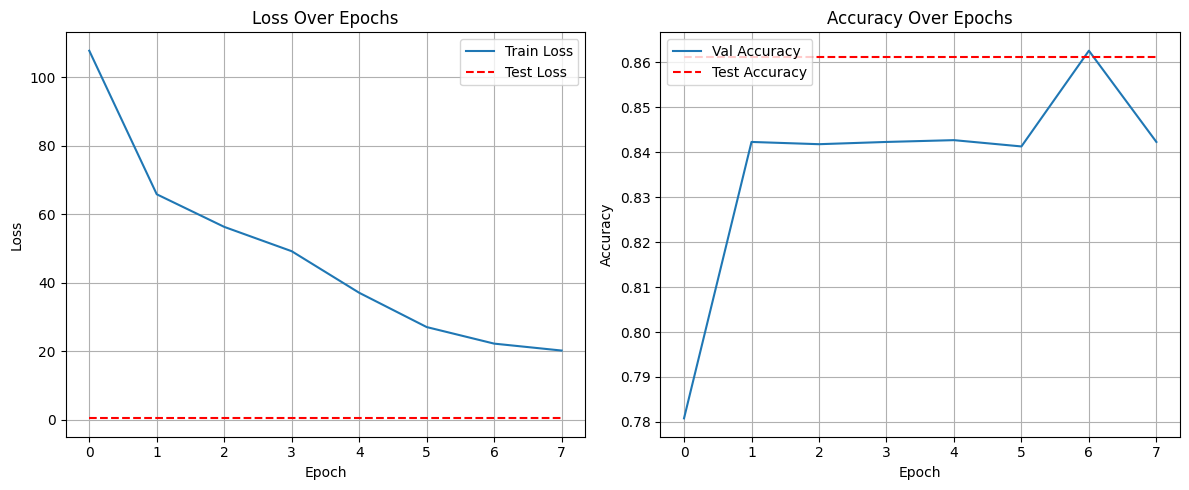

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot (no val_losses)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.hlines(avg_test_loss, 0, len(train_losses)-1, colors="red", linestyles="dashed", label="Test Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Plot (no train_accuracies)
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.hlines(test_accuracy, 0, len(train_losses)-1, colors="red", linestyles="dashed", label="Test Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.73      0.75      0.74       403
Corona Virus Disease       0.97      0.95      0.96       407
              Normal       0.94      0.92      0.93       404
        Tuberculosis       0.96      0.99      0.98       408
     Viral Pneumonia       0.71      0.69      0.70       403

            accuracy                           0.86      2025
           macro avg       0.86      0.86      0.86      2025
        weighted avg       0.86      0.86      0.86      2025



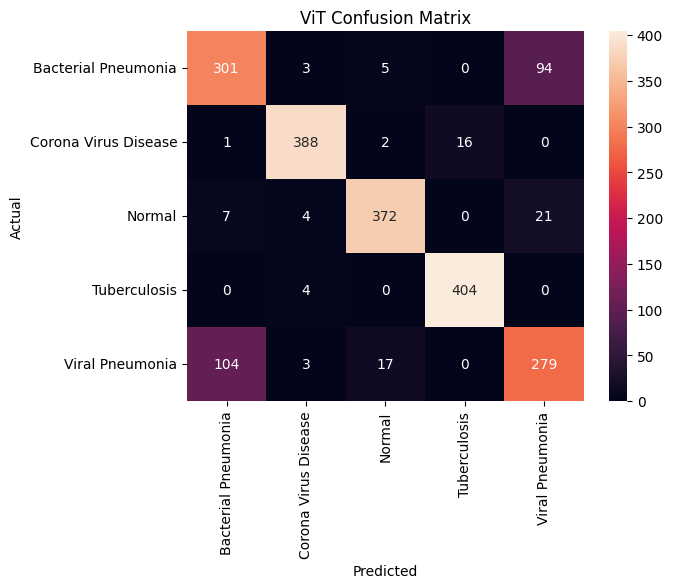

In [ ]:
# ------------------ Step 10: Classification Report ------------------
print(classification_report(y_true, y_pred, target_names=test_data.classes))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ViT Confusion Matrix")
plt.show()

In [ ]:
model.eval()
all_preds = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(probs)

np.save("/content/drive/MyDrive/vit_preds.npy", np.array(all_preds))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [ ]:
import timm

# Define number of classes and load model architecture
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=5)

# Load saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/vit_best.pth"))
model.eval()
model.to("cuda")  # or "cpu" depending on your runtime


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_dataset = datasets.ImageFolder("/content/drive/MyDrive/Lung Disease Dataset/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda")
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Save them
np.save("/content/drive/MyDrive/vit_preds.npy", y_pred)
np.save("/content/drive/MyDrive/y_test.npy", y_true)


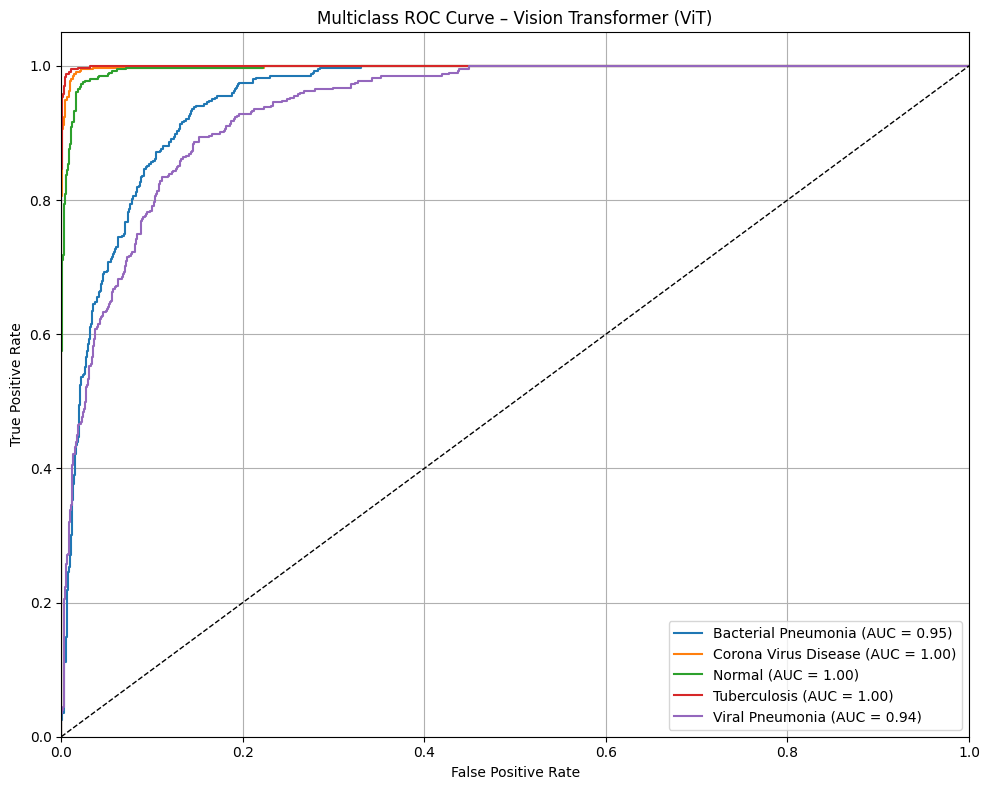

In [ ]:


# Binarize true labels
n_classes = y_pred.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Class names (edit to match your dataset)
class_names = ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

# Plot
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve – Vision Transformer (ViT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
